In [1]:
# Basic set-up
p = 3       # Choose the prime p to calculate with
f = 1       # The degree of the residual field extension
e = 2       # The ramification index
q = p^f

# Define the p-adic field and its ring of integers
o_L.<Pi> = Zp(3, prec=256, type='capped-rel', print_mode='series').ext(x^2-3)
L.<Pi> = Qp(3, prec=256, type='capped-rel', print_mode='series').ext(x^2-3)

# Do linear algebra over the ring of polynomials L[X] in one variable X with coefficients in the field L:
L_X.<X> = L[]
L_Y.<Y> = L[]
v = lambda x: e * L.valuation()(x)

from time import process_time

# Decorator to record execution time
def time_this(func, name=None):
    if name is None:
        name = func.__name__
    
    
    def wrap(*args, **kwargs):
        _start = process_time()
        result = func(*args, **kwargs)
        _end   = process_time()
        
        print(f"{_end-_start : .2f} sec: {name}")
        return result

    return wrap

# The subroutine Dmatrix calculates the following sparse matrix of coefficients.
# Let D[k,n] be equal to k! times the coefficient of Y^k in the polynomial P_n(Y). 
# I compute this using the useful and easy recursion formula 
#      D[k,n] = \sum_{r \geq 0} \pi^{-r} D[k-1,n-q^r] 
# that can be derived from Laurent’s Prop 1.20 of "outline9".
# The algorithm is as follows: first make a zero matrix with S rows and columns (roughly, S is (q-1)*Size), 
# then quickly populate it one row at a time, using the recursion formula.

def Dmatrix(S):
    D = matrix(L, S,S)
    D[0,0] = 1
    for k in range(1,S):
        for n in range(k,S):
            r = 0
            while n >= q^r:
                D[k,n] = D[k,n] + D[k-1,n-q^r]/Pi^r  # the actual recursion 
                r = r+1
    return D


# \Tau^{(m)} in Definition 10.10 of "bounded21":
def TauMatrix(Size, m):
    D = Dmatrix((q - 1) * (Size + 1))
    R = matrix(L, Size,Size, lambda x,y: D[m + (q-1)*x, m + (q-1)*y])

    # Define a diagonal matrix:
    Diag = matrix(L_X, Size,Size, lambda x,y: kronecker_delta(x,y) * X^x)

    # Compute the inverse of R:
    S = R.inverse()    

    # Compute the matrix Tau using Lemma 10.11 in "bounded21":
    Tau = S * Diag * R
    
    return Tau

def underscore(m, i):
    return m + i*(q-1)

# Compute the matrix ( \sigma_{ij}(Y) ) using Proposition 10.6 of "bounded21":
def sigmaMatrix(Size):
    sigma = matrix(L_Y, Size,Size)
    
    for m in [0 .. q-2]:
        Tau = TauMatrix((q-1)*(Size+1), m)
        j = 0
        while underscore(m, j) < Size:
            i = 0
            while underscore(m, i) < Size:
                sigma[underscore(m, i), underscore(m, j)] = Y^m * Tau[i, j](Y^(q-1))
                i += 1
            j += 1
    
    return sigma

# Construct a vwdwo sequence as per Proposition II.2.3 of Cahen-Chabert:
def vwdwo(N):
    u_ = [i for i in range(q)]  # only for L totally ramified
    
    def u(n):
        return o_L(sum(
            u_[n_i] * Pi^i
            for i, n_i in enumerate(Integer(n).digits(base=q))
        ))
    
    return [u(n) for n in [0 .. N]]

# Compute a regular basis (f_n) as per Theorem II.2.7 of Cahen-Chabert:
def regular_basis(N, u):
#     u = vwdwo(N)
    
    def f(n):
        if n == 0:
            return L_Y(1)
        else:
            return prod((Y - u[k]) / (u[n] - u[k]) for k in [0 .. n-1])
    
    return [f(n) for n in [0 .. N]]

# Find b_i in o_L such that P = \sum b_i f_i:
def regular_basis_coeffs_for(P, u, fs):
    n = P.degree(Y)
    bs = [0] * (n + 1)
    for i in [0 .. n]:
        # Since f_i(u_i) = 1; f_j(u_i) = 0 for all j \geq i:
        bs[i] = P(u[i]) - sum(bs[j] * fs[j](u[i]) for j in [0 .. i-1])
    return vector(o_L, bs)
     
def sigma_coeffs_for_basis_iter(M):
    @time_this
    def set_up():        
        with open('w_Qp.txt', 'w') as file:
            file.write('')

        u = vwdwo(M)
        fs = regular_basis(M, u)

        sigma = sigmaMatrix(M + 1)
        return u, fs, sigma
    u, fs, sigma = set_up()
    
    depths = Matrix(QQ, M+1, M+1)  # depths[M, j] = w(M, j), defined below
    depths[0, 0] = 0
    
    m = 0
    P_0 = Q_0 = B = Matrix(o_L, [[1]])
   
    while m < M:
        m += 1
        print()
        print(m)
        
        @time_this
        def fill_B():
            B_new = Matrix(o_L, m+1, binomial(m+2, 2))
            B_new[:m, :B.ncols()] = B
            nb_col = B.ncols()
            for i in [0 .. m]:
                bs = regular_basis_coeffs_for(sigma[i, m], u, fs)
                if any(b != Integer(0) for b in bs):
                    B_new[:len(bs), nb_col] = bs
                    nb_col += 1
            B_new = B_new[:, :nb_col]
            return nb_col, B_new
        nb_col, B = fill_B()
        
        @time_this
        def lift_matrices():
            P_ = block_matrix([ [P_0, 0], [0, identity_matrix(1)] ])  # GL_{m+1}
            Q_ = block_matrix([ [Q_0, 0], [0, identity_matrix(nb_col - Q_0.nrows())] ])  # GL_{nb_col}
            B_ = Matrix(o_L, P_ * B * Q_)
            return P_, Q_, B_
        P_, Q_, B_ = lift_matrices()
        
        A, P, Q = time_this(lambda B: B.smith_form(), f"SNF M={m}")(B_)  # A = P B_ Q = P_ P B Q_ Q

        @time_this
        def compute_depth():            
            P_0 = P * P_
            Q_0 = Q_ * Q

            # For each M, compute the vector of valuations (w(M,j), j=0..M), where:
            # w(M,j) is the least non-negative rational number such that p^{w(M,j)} . f_j lies in S_M
            Z = ~(A[:, :m+1]) * P_0
            depths[m, :m+1] = vector([
                -min(v(x) for x in Z[:, j].list()) 
                for j in [0 .. m]
            ])
            with open('w_Qp.txt', 'a') as file:
                file.write(str(depths[m, :m+1].list()) + '\n')
            return P_0, Q_0
        P_0, Q_0 = compute_depth()
#         print(depths[m, :m+1].list())
    
#     return ~(A[:, :m+1]) * P_0 # nth column is (\beta_{0,n}, ..., \beta_{M,n})^T
#     return depths


In [2]:
M = 100

sigma_coeffs_for_basis_iter(M)

 187.80 sec: set_up

1
 0.07 sec: fill_B
 0.00 sec: lift_matrices
 0.00 sec: SNF M=1
 0.01 sec: compute_depth

2
 0.01 sec: fill_B
 0.00 sec: lift_matrices
 0.00 sec: SNF M=2
 0.01 sec: compute_depth

3
 0.01 sec: fill_B
 0.00 sec: lift_matrices
 0.01 sec: SNF M=3
 0.01 sec: compute_depth

4
 0.02 sec: fill_B
 0.00 sec: lift_matrices
 0.01 sec: SNF M=4
 0.01 sec: compute_depth

5
 0.04 sec: fill_B
 0.00 sec: lift_matrices
 0.02 sec: SNF M=5
 0.02 sec: compute_depth

6
 0.04 sec: fill_B
 0.00 sec: lift_matrices
 0.02 sec: SNF M=6
 0.03 sec: compute_depth

7
 0.07 sec: fill_B
 0.00 sec: lift_matrices
 0.03 sec: SNF M=7
 0.03 sec: compute_depth

8
 0.09 sec: fill_B
 0.01 sec: lift_matrices
 0.04 sec: SNF M=8
 0.03 sec: compute_depth

9
 0.13 sec: fill_B
 0.01 sec: lift_matrices
 0.05 sec: SNF M=9
 0.05 sec: compute_depth

10
 0.16 sec: fill_B
 0.01 sec: lift_matrices
 0.07 sec: SNF M=10
 0.06 sec: compute_depth

11
 0.24 sec: fill_B
 0.01 sec: lift_matrices
 0.08 sec: SNF M=11
 0.07 sec: 

 912.26 sec: compute_depth

88
 123.63 sec: fill_B
 238.25 sec: lift_matrices
 51.54 sec: SNF M=88
 975.99 sec: compute_depth

89
 132.06 sec: fill_B
 249.52 sec: lift_matrices
 54.75 sec: SNF M=89
 1046.04 sec: compute_depth

90
 132.60 sec: fill_B
 257.07 sec: lift_matrices
 56.96 sec: SNF M=90
 1097.68 sec: compute_depth

91
 138.90 sec: fill_B
 276.15 sec: lift_matrices
 59.34 sec: SNF M=91
 1171.33 sec: compute_depth

92
 142.88 sec: fill_B
 286.58 sec: lift_matrices
 61.63 sec: SNF M=92
 1248.29 sec: compute_depth

93
 148.64 sec: fill_B
 298.50 sec: lift_matrices
 64.47 sec: SNF M=93
 1331.49 sec: compute_depth

94
 153.30 sec: fill_B
 321.27 sec: lift_matrices
 67.44 sec: SNF M=94
 1415.22 sec: compute_depth

95
 161.48 sec: fill_B
 336.83 sec: lift_matrices
 70.11 sec: SNF M=95
 1503.51 sec: compute_depth

96
 164.23 sec: fill_B
 348.95 sec: lift_matrices
 73.70 sec: SNF M=96
 1594.48 sec: compute_depth

97
 173.44 sec: fill_B
 370.68 sec: lift_matrices
 76.65 sec: SNF M=97
 1

In [3]:
# M = 100

depths = Matrix(QQ, M+1, M+1)
with open('w_Qp.txt', 'r') as data:
    for i, raw_line in enumerate(data.readlines()):
        line = vector(eval(raw_line))
        depths[i+1, :len(line)] = line
depths

101 x 101 dense matrix over Rational Field (use the '.str()' method to see the entries)

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib


In [5]:
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['figure.figsize'] = (10, 5)

plt.style.use('bmh')

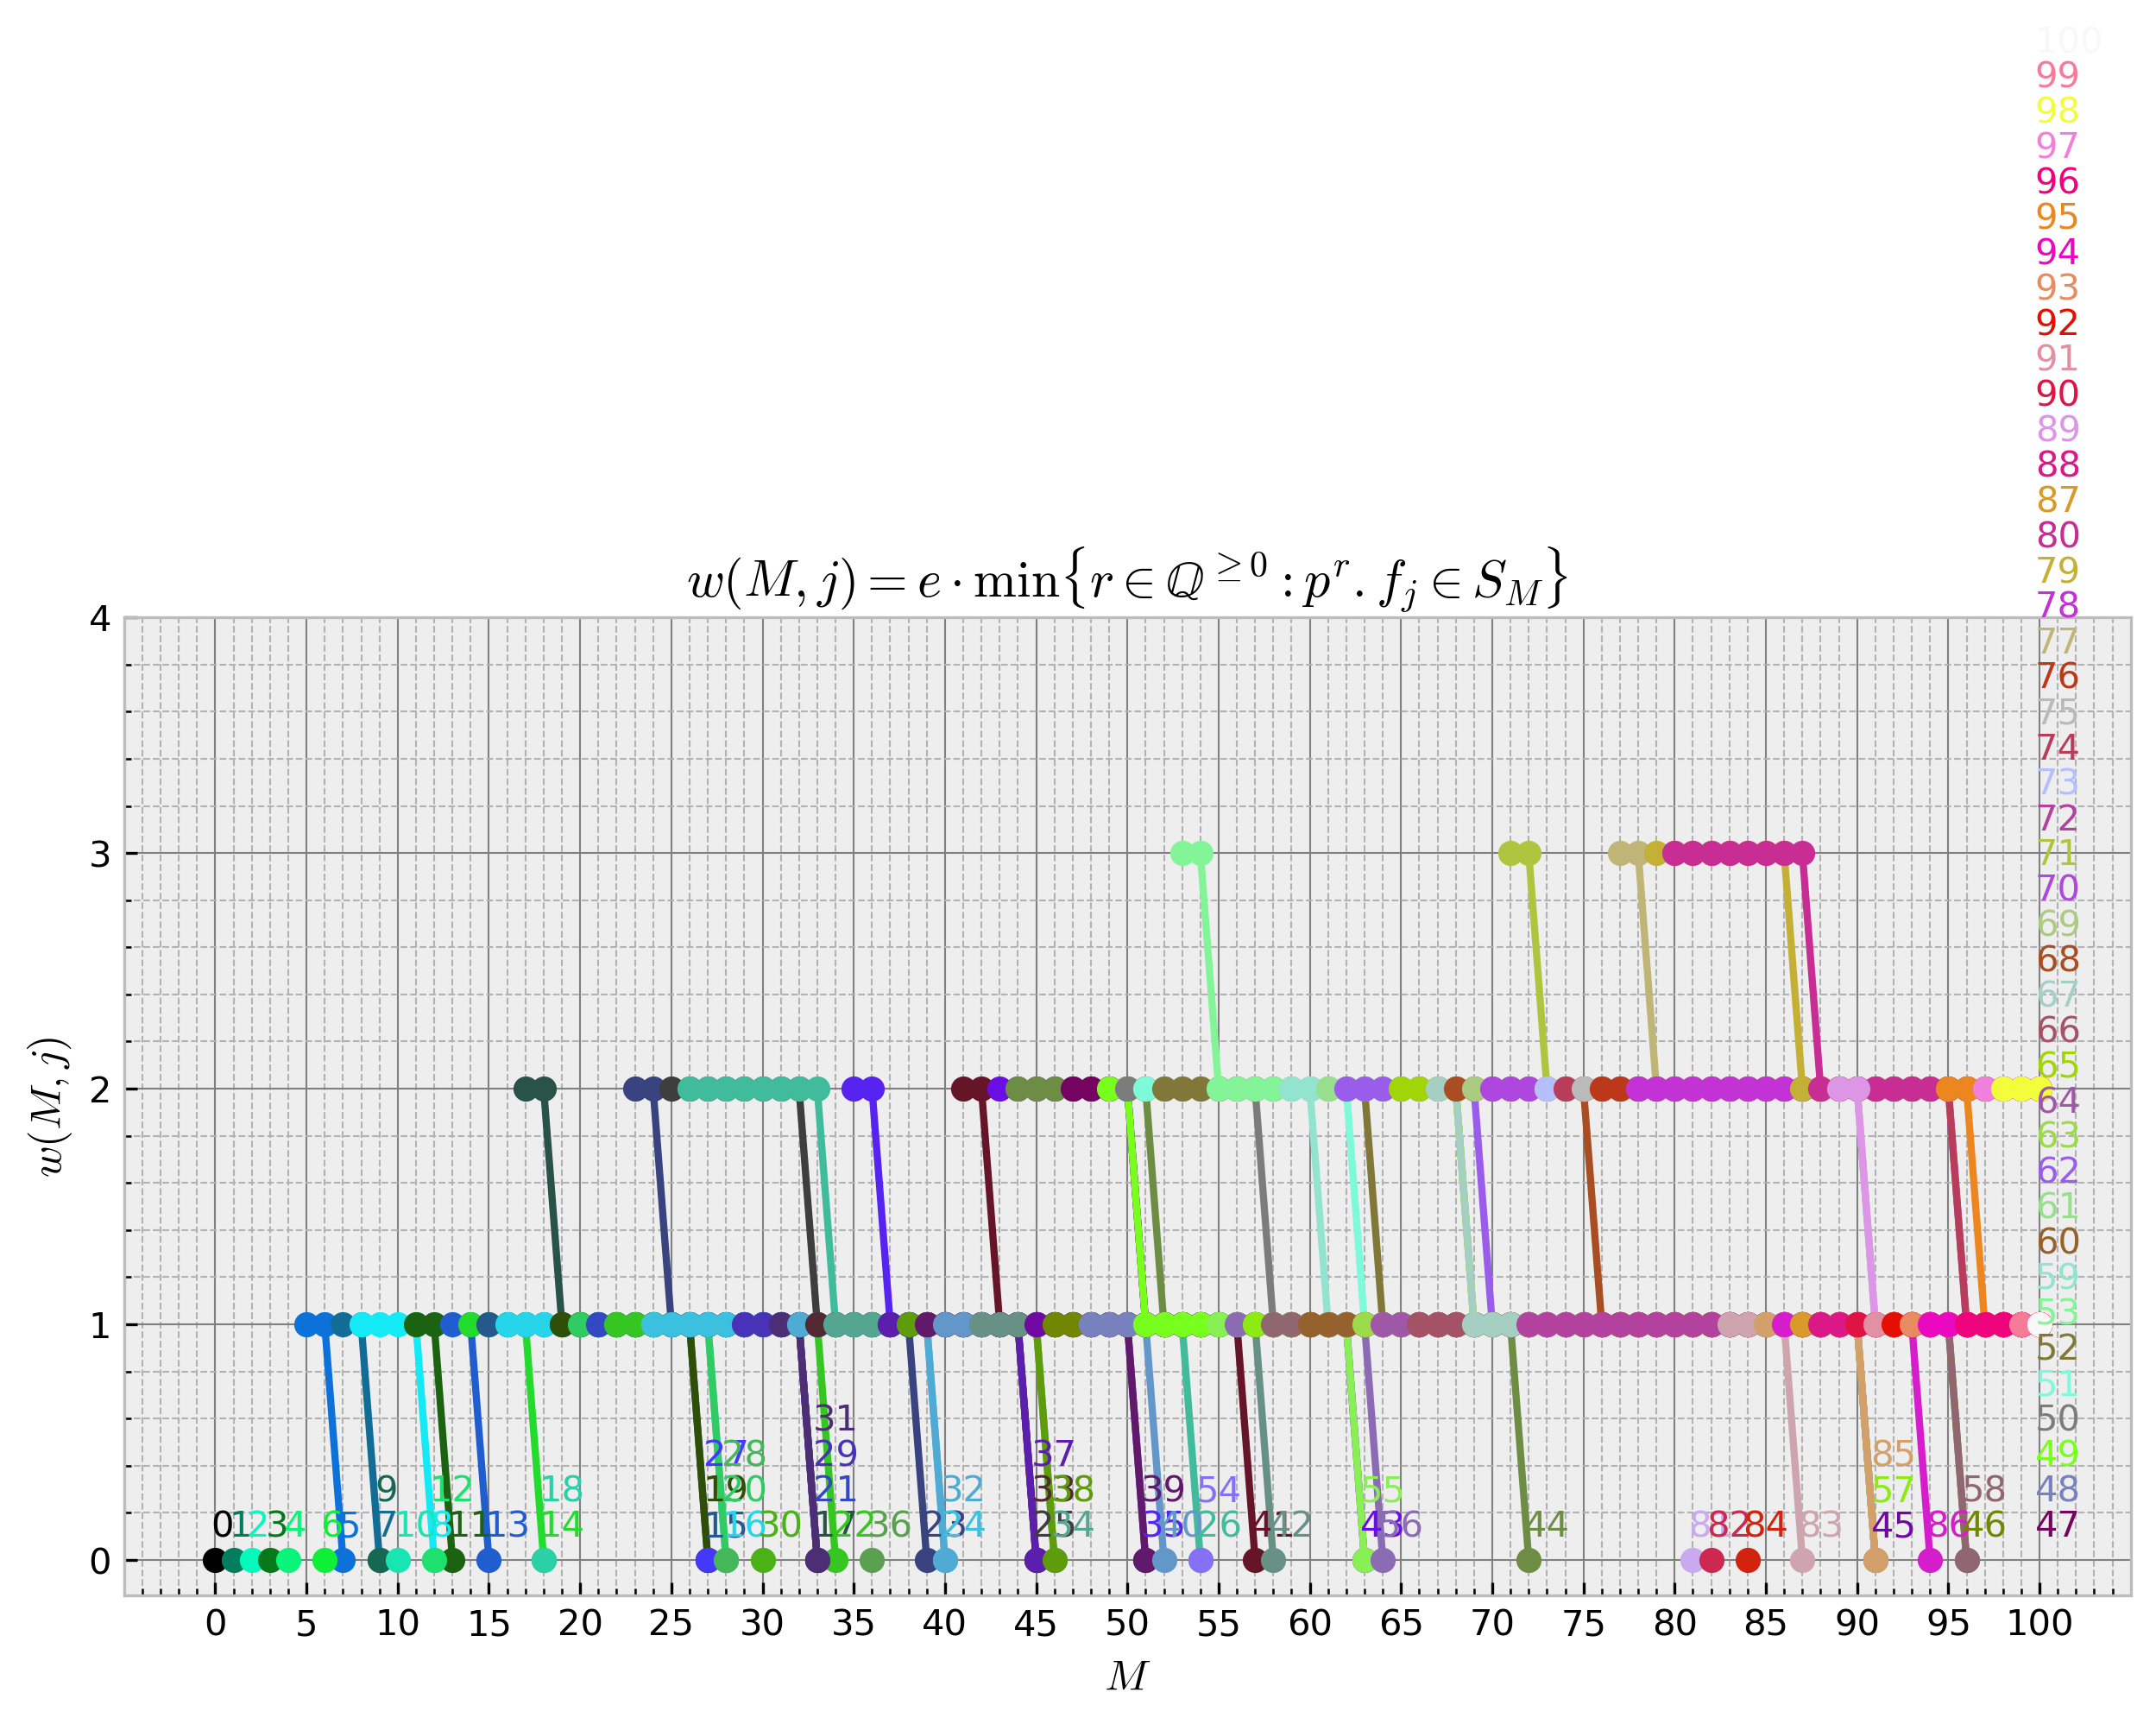

In [6]:
def color_for(j):
    c = hex(int(0xF8F8F8 * j/M))
    s = str(c)[2:]
    return '#' + '0'*(6-len(s)) + s

plt.figure()
captions = {j: [] for j in [0 .. M]}
for j in [0 .. M]:
    ws = depths[j:, j].list()
    if 0 in ws:
        ws = ws[:ws.index(0) + 1]  # crop further zeroes 
    j_ = j + len(ws) - 1
    captions[j_].append(j)
    xs = [j .. j_]
    plt.plot(xs, ws, '-o', c=color_for(j))
for j_ in [0 .. M]:
    for i, j in enumerate(captions[j_]):
        plt.text(j_ - 0.25, 0.1 + .15*i, str(j), color=color_for(j))
plt.xlabel("$M$")
plt.ylabel("$w(M, j)$")
plt.title(r"$w(M, j) = e \cdot \min\{ r \in \mathbb{Q}^{\geq 0} : p^r . f_j \in S_M \}$")
plt.xticks(range(0, M+1, 5))
plt.yticks(range(0, 5))
plt.minorticks_on()
plt.grid(which='minor')
plt.grid(which='major', linestyle='-', c='grey')
plt.show()

In [7]:
js = []
j_s = []
Cs = []
Xs = []

for j in [0 .. M]:
    ws = depths[j:, j].list()
    if 0 in ws:
        js.append(j)
        Cs.append(ws.index(0) + j)
        Xs.append(ws.index(0))
    else:
        j_s.append(j)


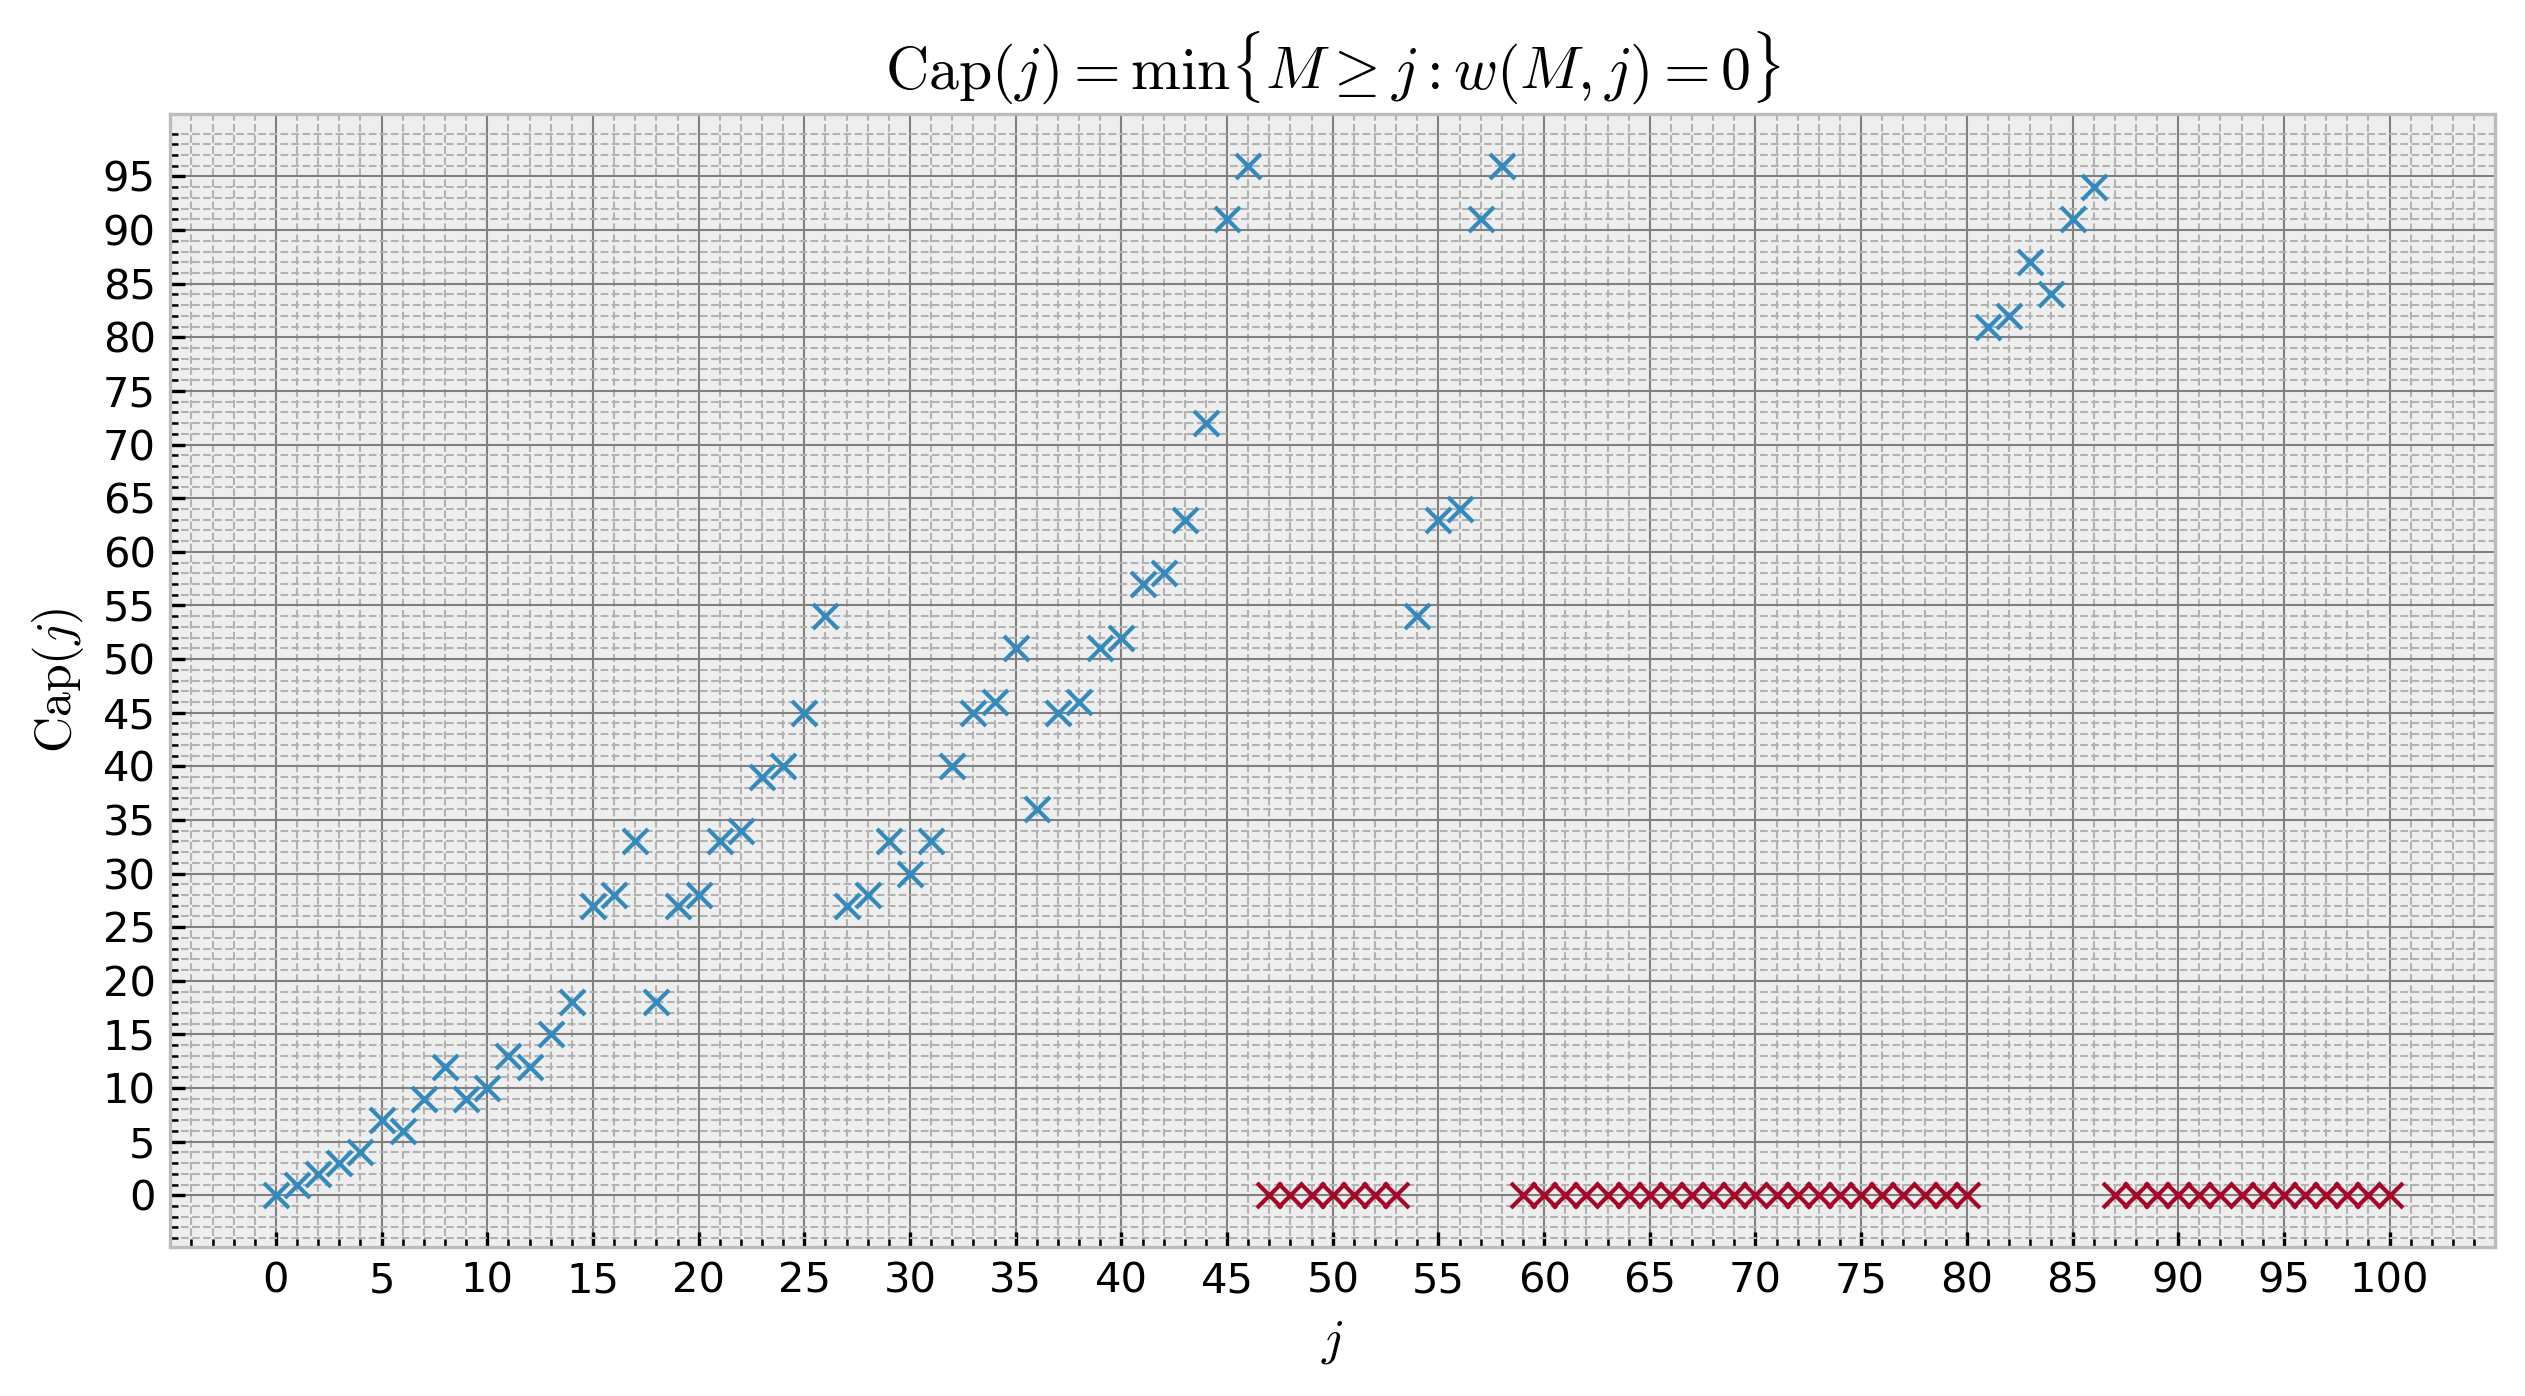

In [8]:
plt.plot(js, Cs, 'x')
plt.plot(j_s, [0]*len(j_s), 'x')
plt.xticks(range(0, M+1, 5))
plt.yticks(range(0, max(Cs)+1, 5))
plt.xlabel("$j$")
plt.ylabel(r"$\mathrm{Cap}(j)$")
plt.title(r"$\mathrm{Cap}(j) = \min\{M \geq j : w(M, j) = 0\}$")
plt.minorticks_on()
plt.grid(which='minor')
plt.grid(which='major', linestyle='-', c='grey')
plt.show()

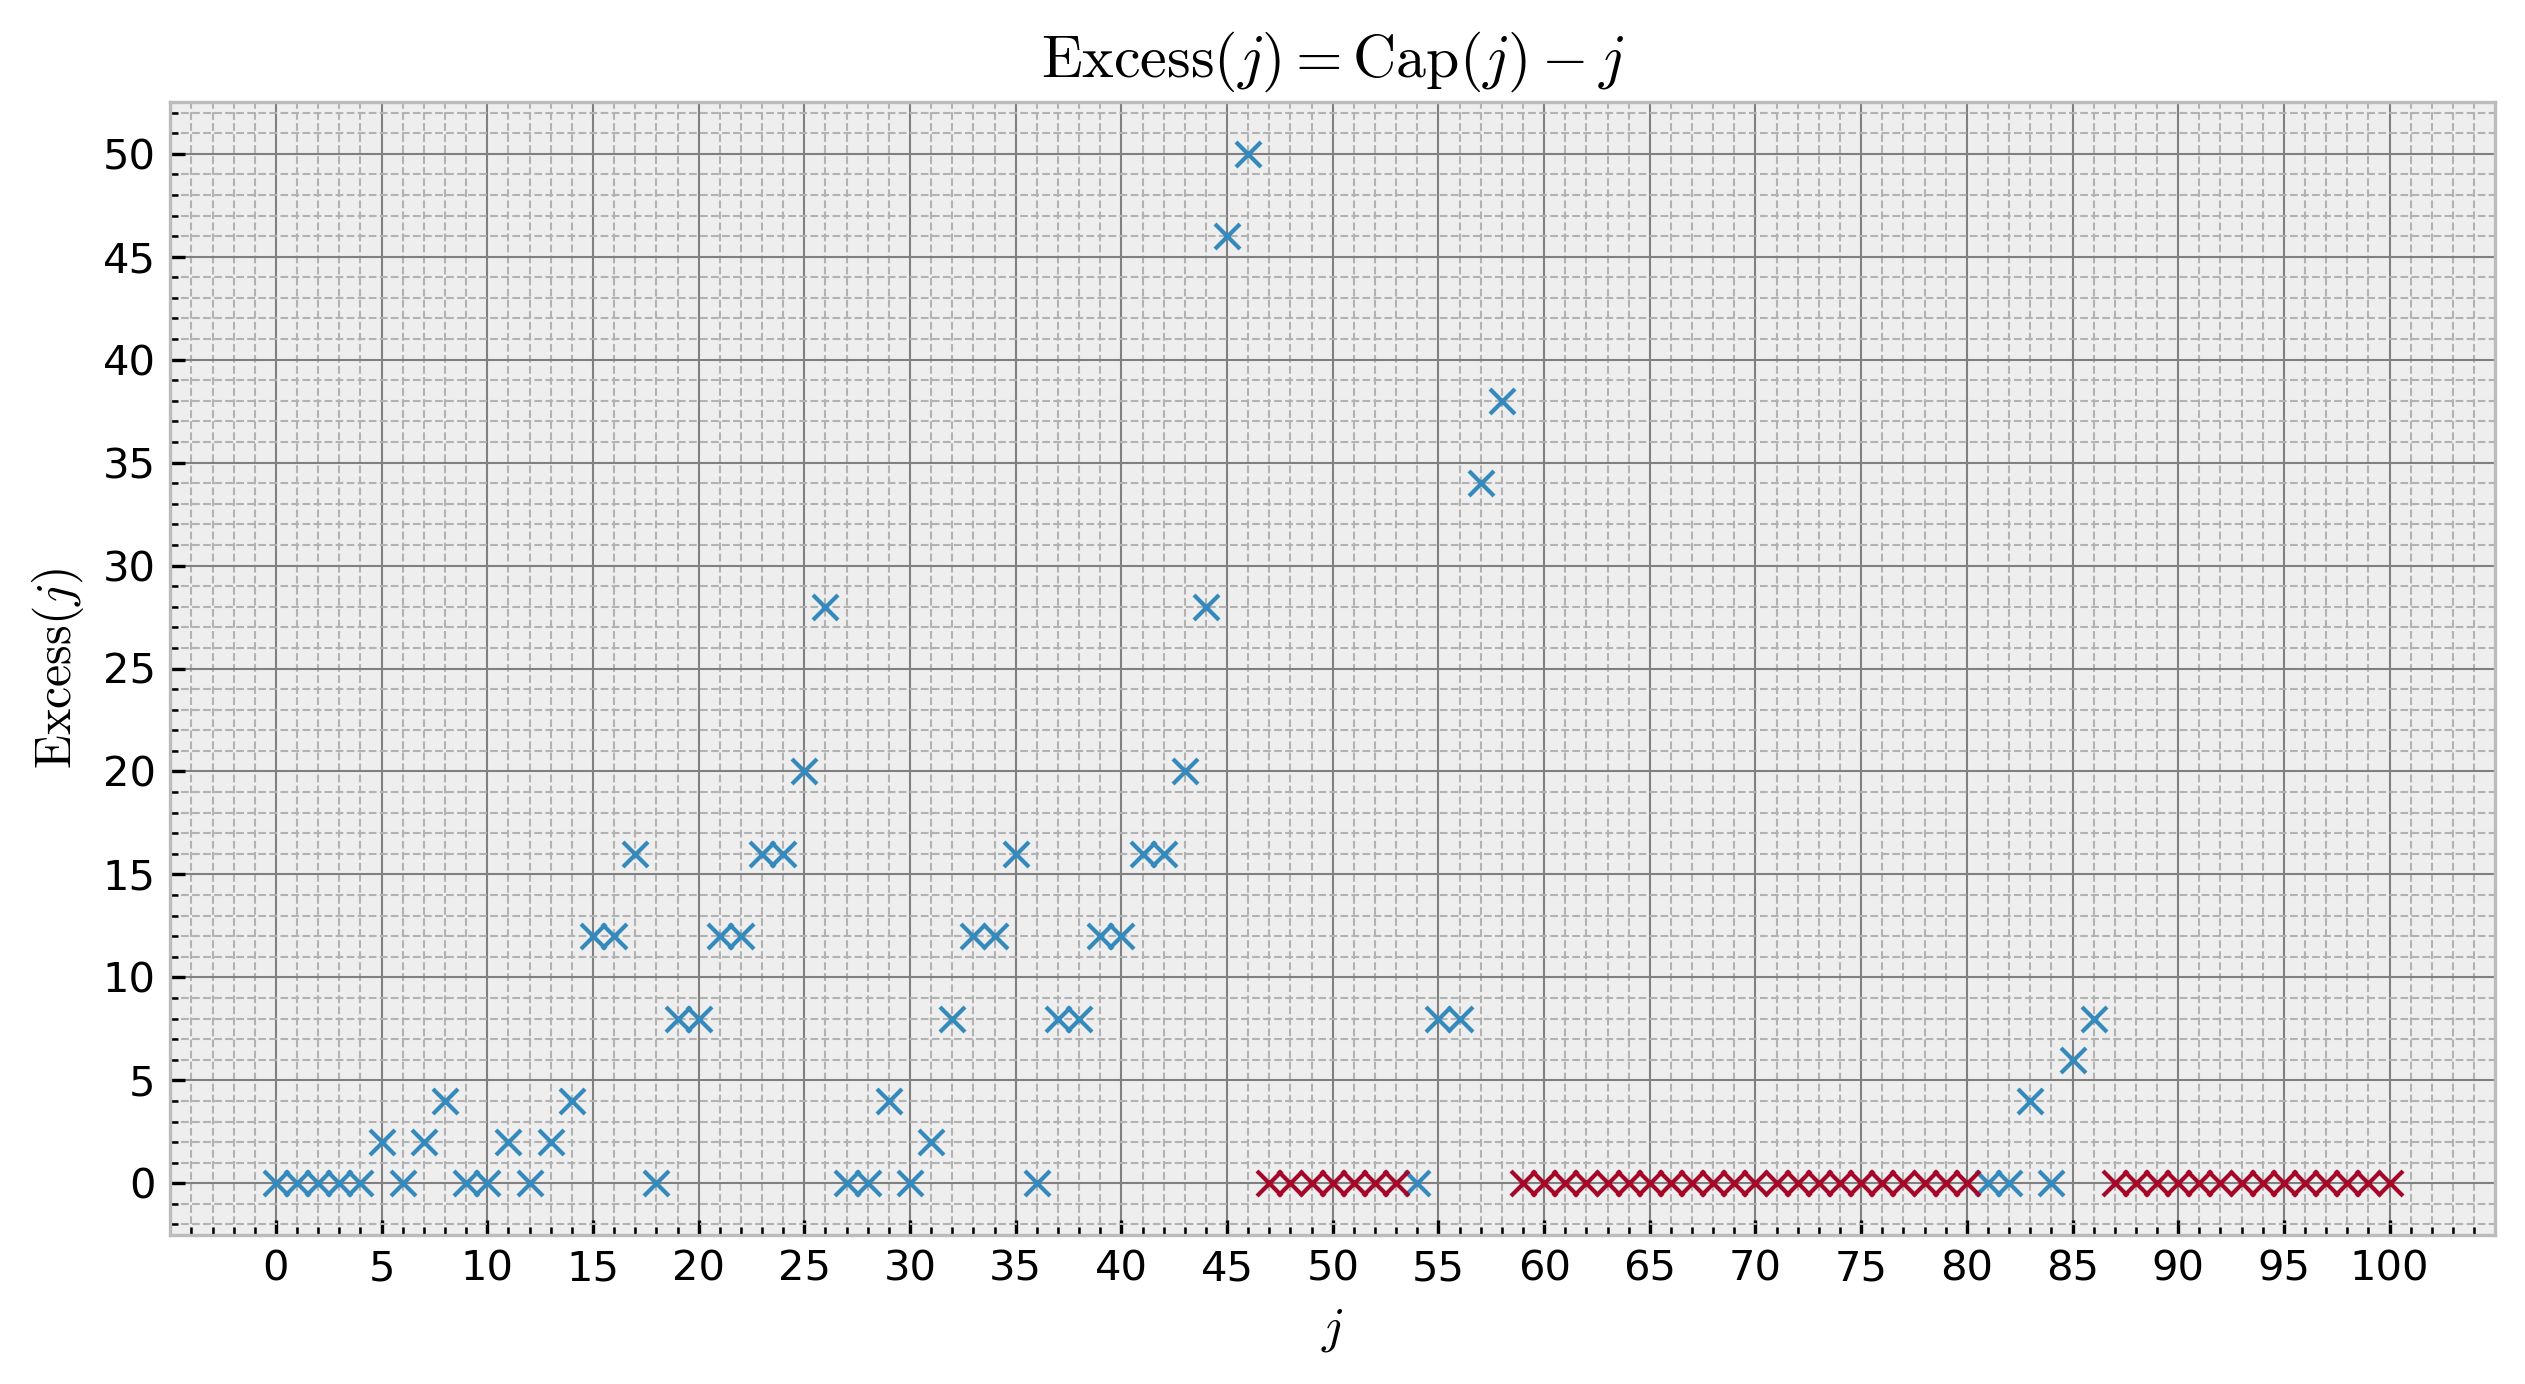

In [9]:
plt.plot(js, Xs, 'x')
plt.plot(j_s, [0]*len(j_s), 'x')
plt.xticks(range(0, M+1, 5))
plt.yticks(range(0, max(Xs)+1, 5))
plt.xlabel("$j$")
plt.ylabel(r"$\mathrm{Excess}(j)$")
plt.title(r"$\mathrm{Excess}(j) = \mathrm{Cap}(j) - j$")
plt.minorticks_on()
plt.grid(which='minor')
plt.grid(which='major', linestyle='-', c='grey')
plt.show()

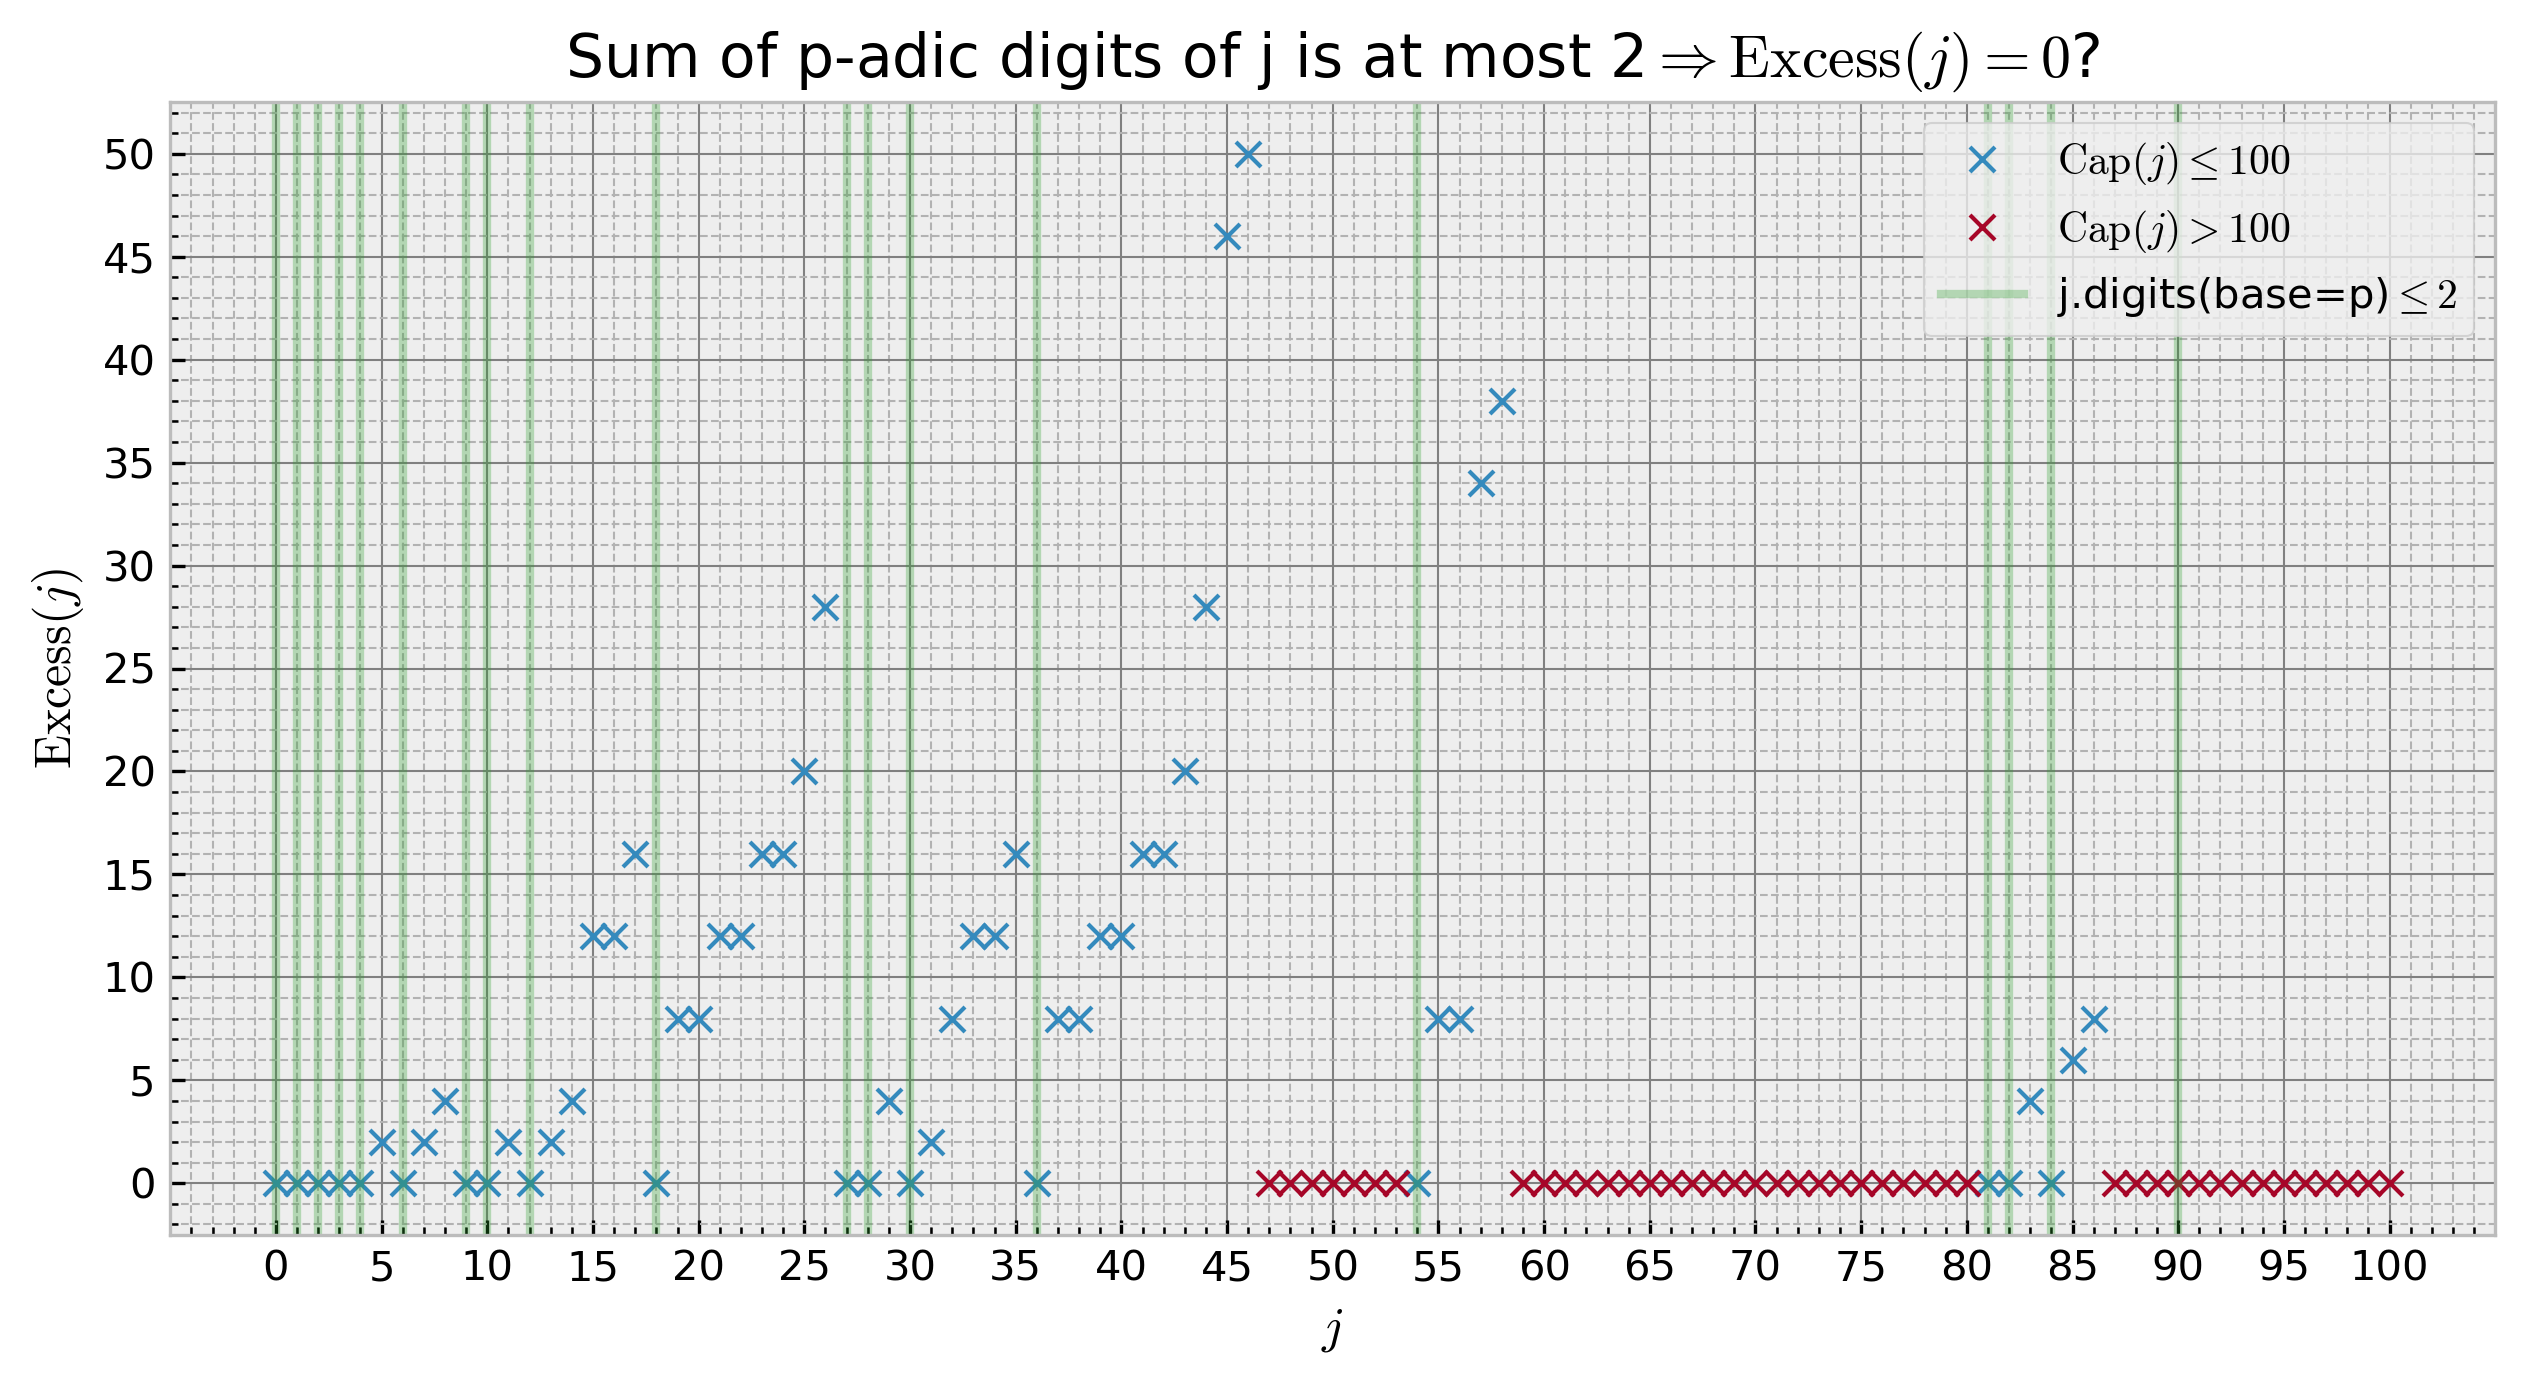

In [10]:
plt.plot(js, Xs, 'x')
plt.plot(j_s, [0]*len(j_s), 'x')

for j in [0 .. M]:
    if sum(j.digits(base=p)) <= 2:
        plt.axvline(x=j, c='#2ca02c', alpha=.3)
plt.legend([r"$\mathrm{Cap}(j) \leq 100$", r"$\mathrm{Cap}(j) > 100$", r"j.digits(base=p)$\leq 2$"])
        
plt.xticks(range(0, M+1, 5))
plt.yticks(range(0, max(Xs)+1, 5))
plt.xlabel("$j$")
plt.ylabel(r"$\mathrm{Excess}(j)$")
plt.title(r"Sum of p-adic digits of j is at most 2$\Rightarrow \mathrm{Excess}(j) = 0$?")
plt.minorticks_on()
plt.grid(which='minor')
plt.grid(which='major', linestyle='-', c='grey')
plt.show()

# 